In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def MinFilterGray(src, r=17):
    # 最小值滤波器
    return cv2.erode(src, np.ones((2*r+1, 2*r+1)))

In [3]:
def guidedfilter(I, p, r, eps):
    height, width = I.shape
    m_I = cv2.boxFilter(I, -1, (r, r))
    m_p = cv2.boxFilter(p, -1, (r, r))
    m_Ip = cv2.boxFilter(I*p, -1, (r, r))
    cov_Ip = m_Ip-m_I*m_p

    m_II = cv2.boxFilter(I*I, -1, (r, r))
    var_I = m_II-m_I*m_I

    a = cov_Ip/(var_I+eps)
    b = m_p-a*m_I

    m_a = cv2.boxFilter(a, -1, (r, r))
    m_b = cv2.boxFilter(b, -1, (r, r))
    return m_a*I+m_b


def getV1(m, r, eps, w, maxV1):   # 输入RGB图  范围[0,1]
    # 计算大气遮罩图像V1和光照值A, V1 = 1-t/A
    # 获取暗道图
    V1 = np.min(m, 2)
    # 使用引导滤波优化
    V1 = guidedfilter(V1, MinFilterGray(V1, 7), r, eps)
    bins = 2000
    ht = np.histogram(V1, bins)
    d = np.cumsum(ht[0])/float(V1.size)
    for lmax in range(bins-1, 0, -1):
        if d[lmax] <= 0.999:
            break
    A = np.mean(m, 2)[V1 >= ht[1][lmax]].max()  # 大气光照A
    V1 = np.minimum(V1*w, maxV1)

    return V1, A


In [4]:
def deHaze(m, r=27, eps=0.01, w=0.9, maxV1=0.9, bGamma=False):
    Y = np.zeros(m.shape)
    V1, A = getV1(m, r, eps, w, maxV1)  # 得到遮罩图像和大气光照
    for k in range(3):
        Y[:, :, k] = (m[:, :, k]-V1)/(1-V1/A)  # 颜色校正
    Y = np.clip(Y, 0, 1)
    if bGamma:
        Y = Y**(np.log(0.5)/np.log(Y.mean()))
    return Y


# 图像去雾结果展示

In [6]:
def plot_(img_path):
    img_in = cv2.imread(img_path)
    # 去雾的效果图
    defog = deHaze(img_in/255.0)*255
    # 去雾效果+Gamma拉伸
    defog_gamma = deHaze(img_in / 255.0, bGamma=True) * 255
    defog = cv2.cvtColor(defog.astype(np.uint8), cv2.COLOR_BGR2RGB)
    img_in = cv2.cvtColor(img_in.astype(np.uint8), cv2.COLOR_BGR2RGB)
    defog_gamma = cv2.cvtColor(defog_gamma.astype(np.uint8), cv2.COLOR_BGR2RGB)
    # 汇总显示图片 进行对比
    fig = plt.figure(figsize=(18, 12))
    plt.subplot(221)
    plt.title('img_in', fontsize=15)
    plt.imshow(img_in)
    plt.subplot(222)
    plt.title('defog', fontsize=15)
    plt.imshow(defog)
    plt.subplot(223)
    plt.title('defog_gamma', fontsize=15)
    plt.imshow(defog_gamma)
    plt.show()


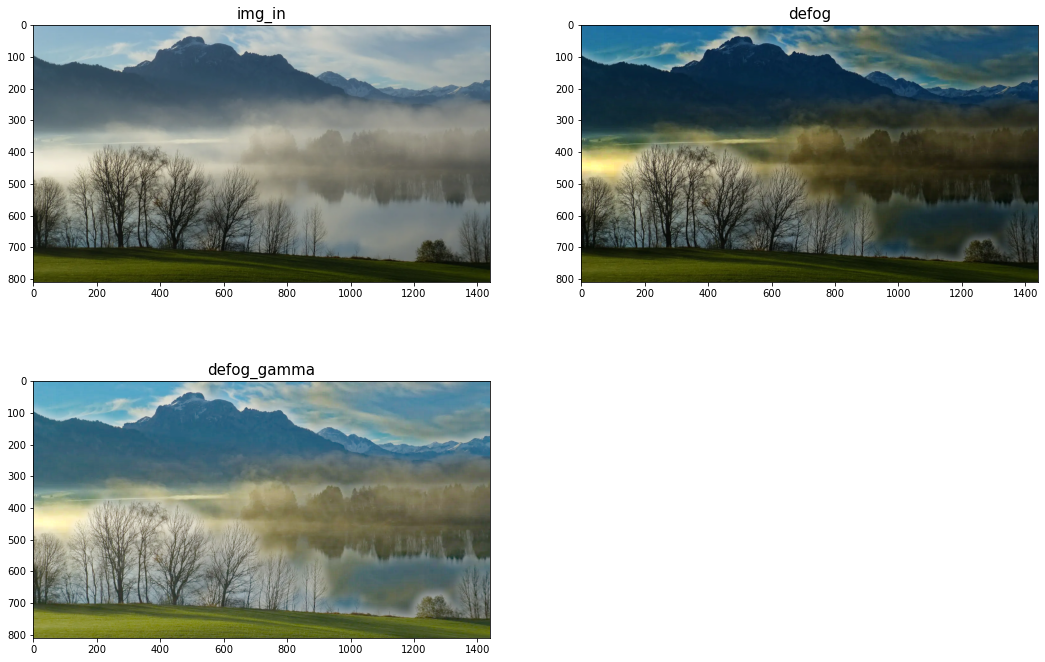

In [7]:
plot_('img/haze.png')

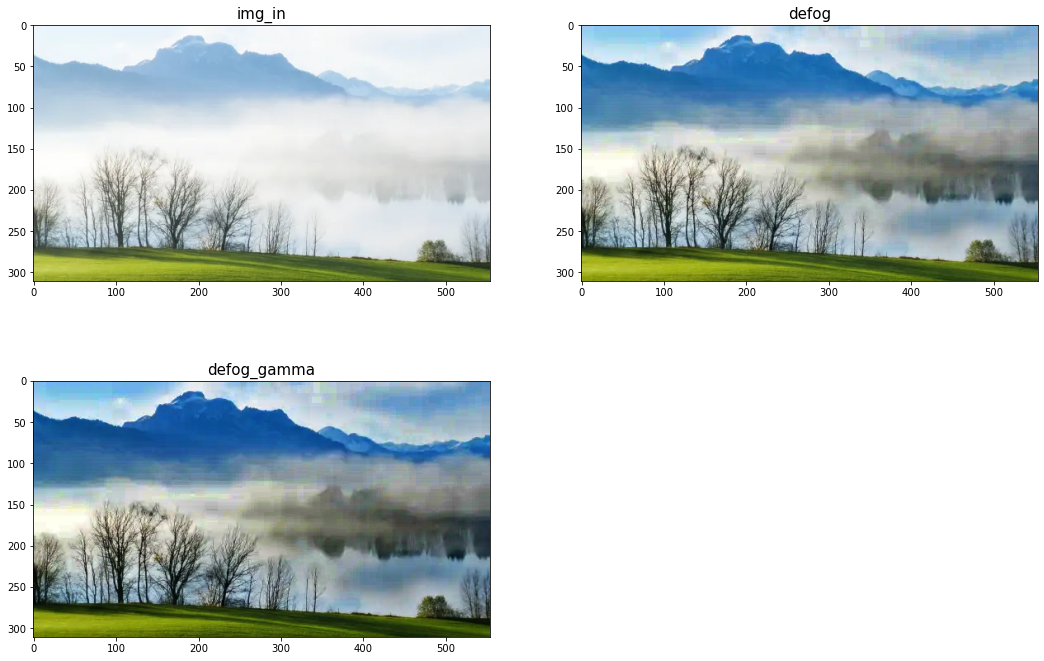

In [8]:
plot_('img/haze2.png')